<a href="https://colab.research.google.com/github/Vibhuarvind/Depression-Detect/blob/main/Audio/SVM_Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
### General imports ###
from glob import glob
import os
import pickle
import itertools
import pandas as pd
import numpy as np

### Warning import ###
import warnings
warnings.filterwarnings('ignore')

### Graph imports ###
import matplotlib.pyplot as plt

### Sklearn imports ###
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [ ]:
# Load datas from pickle
[features, labels] = pickle.load(open("/content/drive/MyDrive/models/[RAVDESS][HAP-SAD-NEU-ANG-FEA-DIS-SUR][GLOBAL_STATS].p", "rb"))

In [ ]:
# Build Train and test dataset
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=123)

# Encode Label from categorical to numerical
lb = LabelEncoder()
lb.fit(y_train)
y_train, y_test = lb.transform(y_train), lb.transform(y_test)

In [ ]:
# Scale train and test dataset
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

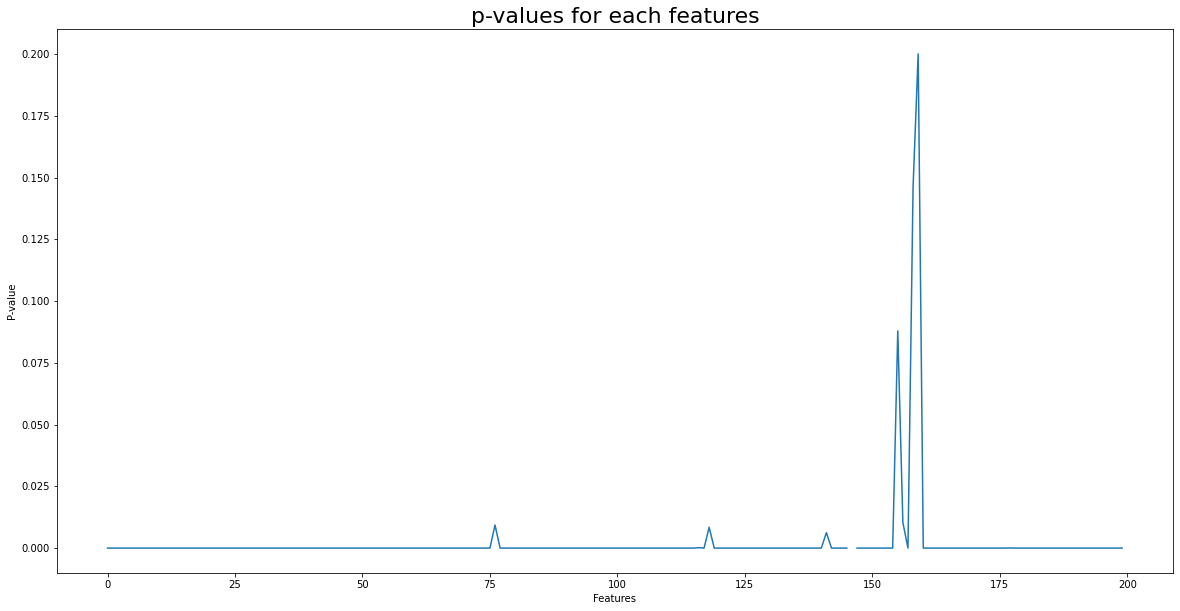

Number of p-values > à 1% : 4


In [ ]:
# k-highest scores analysis on features
Kbest = SelectKBest(k="all")
selected_features = Kbest.fit(X_train, y_train)

# Plot P-values
plt.figure(figsize=(20, 10))
plt.plot(selected_features.pvalues_)
plt.title("p-values for each features", fontsize=22)
plt.xlabel("Features")
plt.ylabel("P-value")
plt.show()

# Display Comment
alpha = 0.01
print("Number of p-values > à 1% : {}".format(np.sum(selected_features.pvalues_ > alpha)))

In [ ]:
# Remove non-significant features
X_train = X_train[:,np.where(selected_features.pvalues_ < alpha)[0]]
X_test = X_test[:,np.where(selected_features.pvalues_ < alpha)[0]]

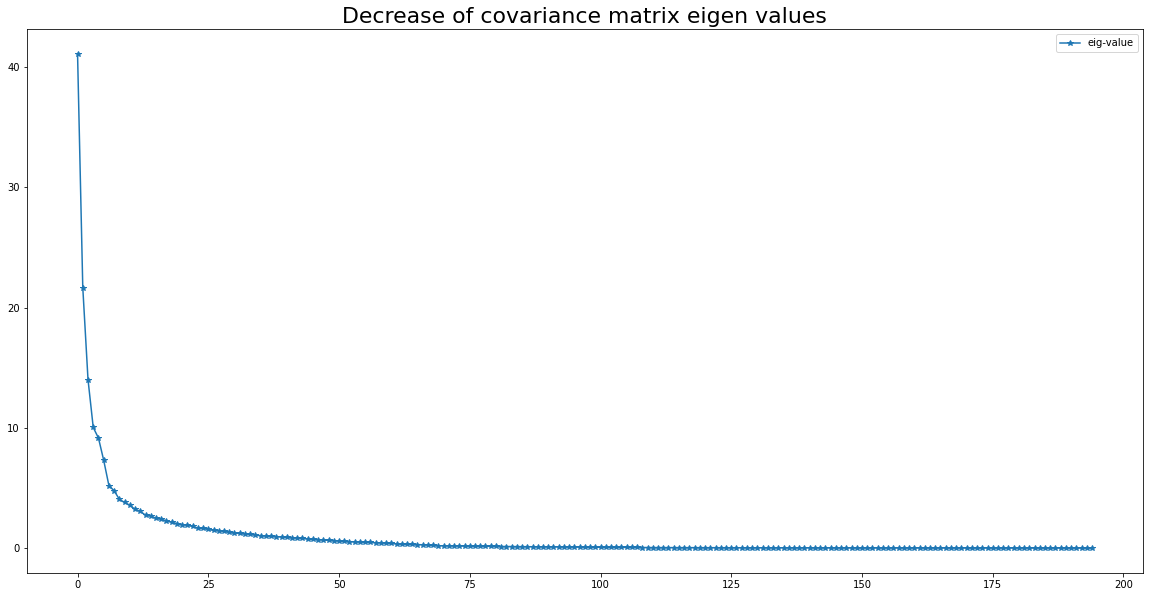

In [ ]:
# Covariance matrix
cov = pd.DataFrame(X_train).cov()

# Eigen values of covariance matrix
eig = np.linalg.svd(cov)[1]

# Plot eigen graph
fig = plt.figure(figsize=(20, 10))
plt.title('Decrease of covariance matrix eigen values', fontsize = 22)
plt.plot(eig, '-*', label = "eig-value")
plt.legend(loc = 'upper right')
plt.show()

In [ ]:
# Initialize PCA
pca = PCA(n_components=140)

# Apply PCA on train and test set
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [ ]:
# Set C and Gamma parameters list
G_list = [0.001, 0.005, 0.01]
C_list = [1, 2, 3, 4, 5, 7, 10, 20, 50]

# Set the parameters for cross-validation
parameters = [{'kernel': ['rbf'], 'C': C_list, 'gamma': G_list}]

# Initialize SVM model
model = SVC(decision_function_shape='ovr')

# Cross Validation 
cv = GridSearchCV(model, parameters, cv=3, verbose=0, n_jobs=-1).fit(X_train, y_train)

# Print Best parameters
print("Best parameters set found on train set:")
print(cv.best_params_)

Best parameters set found on train set:
{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}


In [ ]:
# Confusion matrix plot function
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=22)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=18)
    plt.xlabel('Predicted label', fontsize=18)
    plt.tight_layout()

Accuracy Score on test dataset: 68.03%


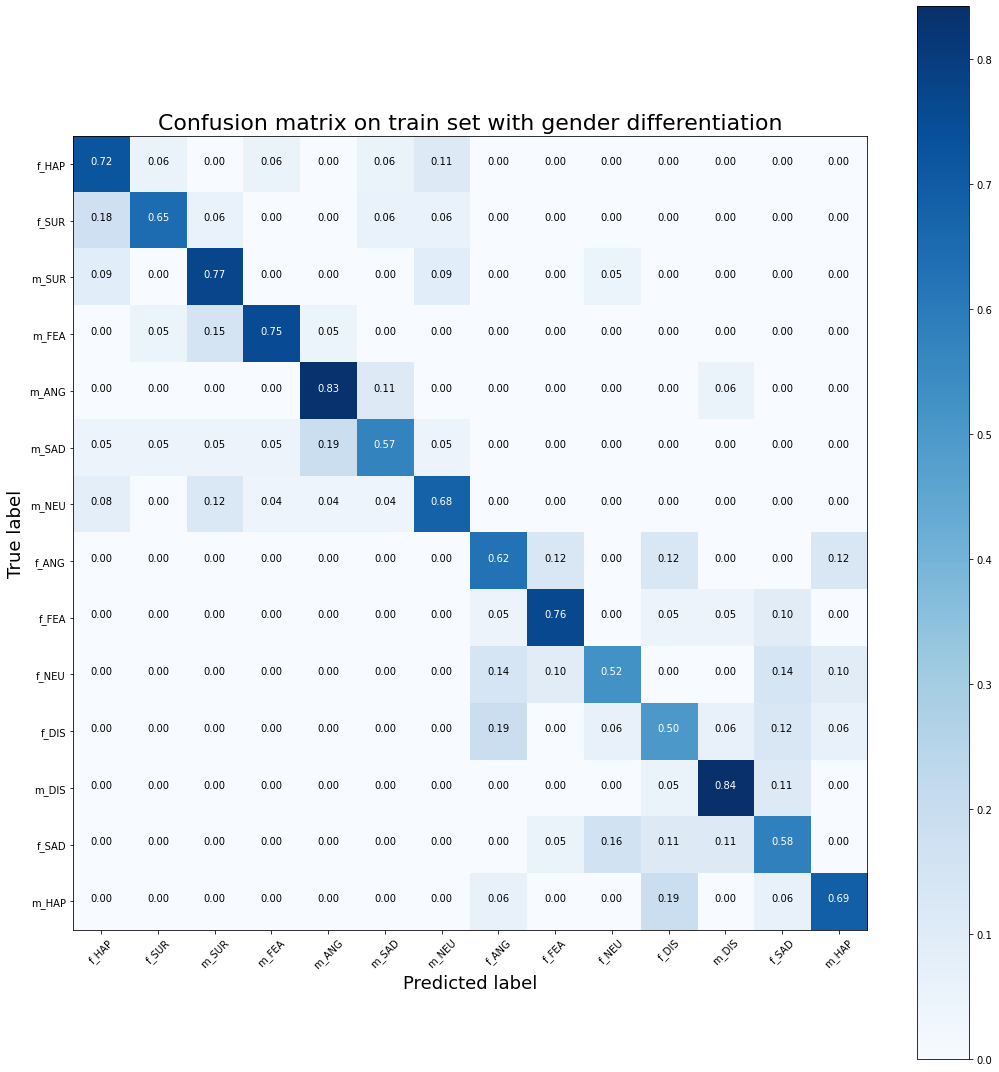

In [ ]:
# Fit best mode
model = SVC(kernel='rbf', C=3, gamma=0.005, decision_function_shape='ovr').fit(X_train, y_train)

# Prediction
pred = model.predict(X_test)

# Score
score = model.score(X_test, y_test)

# Reverse label encoder
pred = (lb.inverse_transform((pred.astype(int).flatten())))
actual = (lb.inverse_transform((y_test.astype(int).flatten())))

# Build dataFrame
df_pred = pd.DataFrame({'Actual': actual, 'Prediction': pred})

# Print Score
print('Accuracy Score on test dataset: {}%'.format(np.round(100 * score,2)))

# Compute confusion matrix
confusion = confusion_matrix(actual, pred)

# Plot non-normalized confusion matrix
plt.figure(figsize=(15, 15))
plot_confusion_matrix(confusion, classes=set(actual),normalize=True,
                      title='Confusion matrix on train set with gender differentiation')

Accuracy Score on test dataset: 68.77%


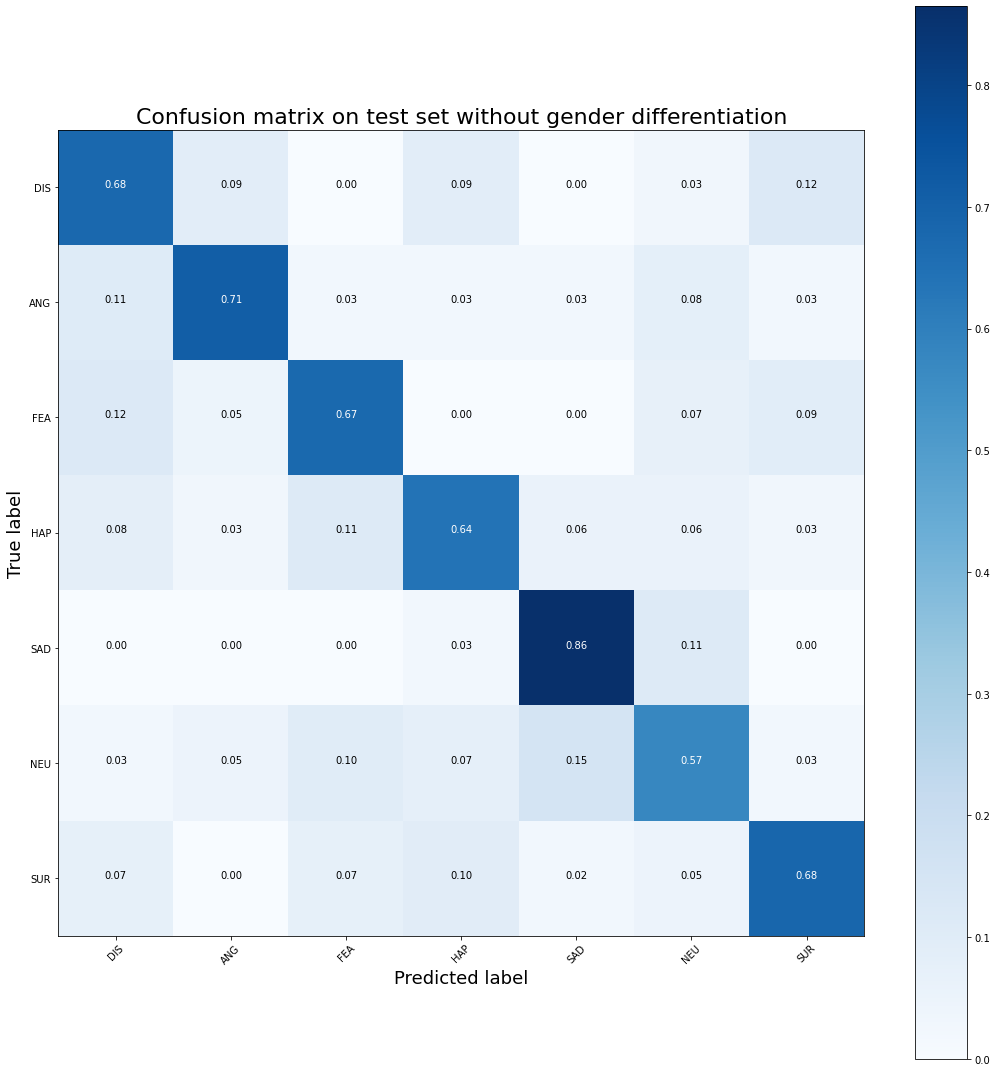

In [ ]:
# Compute prediction without gender differentation
PRED = list(map(lambda i:i[2:], pred))
ACTUAL = list(map(lambda i:i[2:], actual))

# Compute related prediction score
SCORE = accuracy_score(ACTUAL, PRED)

# Print Score
print('Accuracy Score on test dataset: {}%'.format(np.round(100 * SCORE,2)))

# Compute confusion matrix
confusion = confusion_matrix(ACTUAL, PRED)

# Plot non-normalized confusion matrix
plt.figure(figsize=(15, 15))
plot_confusion_matrix(confusion, classes=set(ACTUAL),normalize=True,
                      title='Confusion matrix on test set without gender differentiation')

In [ ]:
# save the model to local
pickle.dump(model, open('/content/drive/MyDrive/models/MODEL_CLASSIFIER.p', 'wb'))

# Save label encoder
pickle.dump(lb, open("/content/drive/MyDrive/models/MODEL_ENCODER.p", "wb"))

# Save PCA
pickle.dump(pca, open("/content/drive/MyDrive/models/MODEL_PCA.p", "wb"))

# Save MEAN and STD of each features
MEAN = features.mean(axis=0)
STD = features.std(axis=0)
pickle.dump([MEAN, STD], open("/content/drive/MyDrive/models/MODEL_SCALER.p", "wb"))

# Save feature parameters
stats = ['mean', 'std', 'kurt', 'skew', 'q1', 'q99']
features_list = ['zcr', 'energy', 'energy_entropy', 'spectral_centroid', 'spectral_spread', 'spectral_entropy', 'spectral_flux', 'sprectral_rolloff']
win_step = 0.01
win_size = 0.025
nb_mfcc = 12
diff = 0
PCA = True
DICO = {'stats':stats, 'features_list':features_list, 'win_size':win_size, 'win_step':win_step, 'nb_mfcc':nb_mfcc, 'diff':diff, 'PCA':PCA}
pickle.dump(DICO, open("/content/drive/MyDrive/models/MODEL_PARAM.p", "wb"))